In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

#1. Limpieza de Datos

In [97]:
#1.1 Carga del dataset

df =  pd.read_csv('../../../data/diabetes.csv')

df.head(5)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [98]:
df.info()

# Mediante la funcion info() podemos percatarnos que todos los datos son del tipo numerico, ya sea decimales o enteros

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [99]:
# Eliminacion de valores duplicados

df = df.drop_duplicates()

# Manejo de valores faltantes

faltantes_por_columna = df.isnull().sum()
print(faltantes_por_columna)

# No existen valores faltantes en este dataset



Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


#2. Exploracion de datos

Estadísticas Descriptivas:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min     

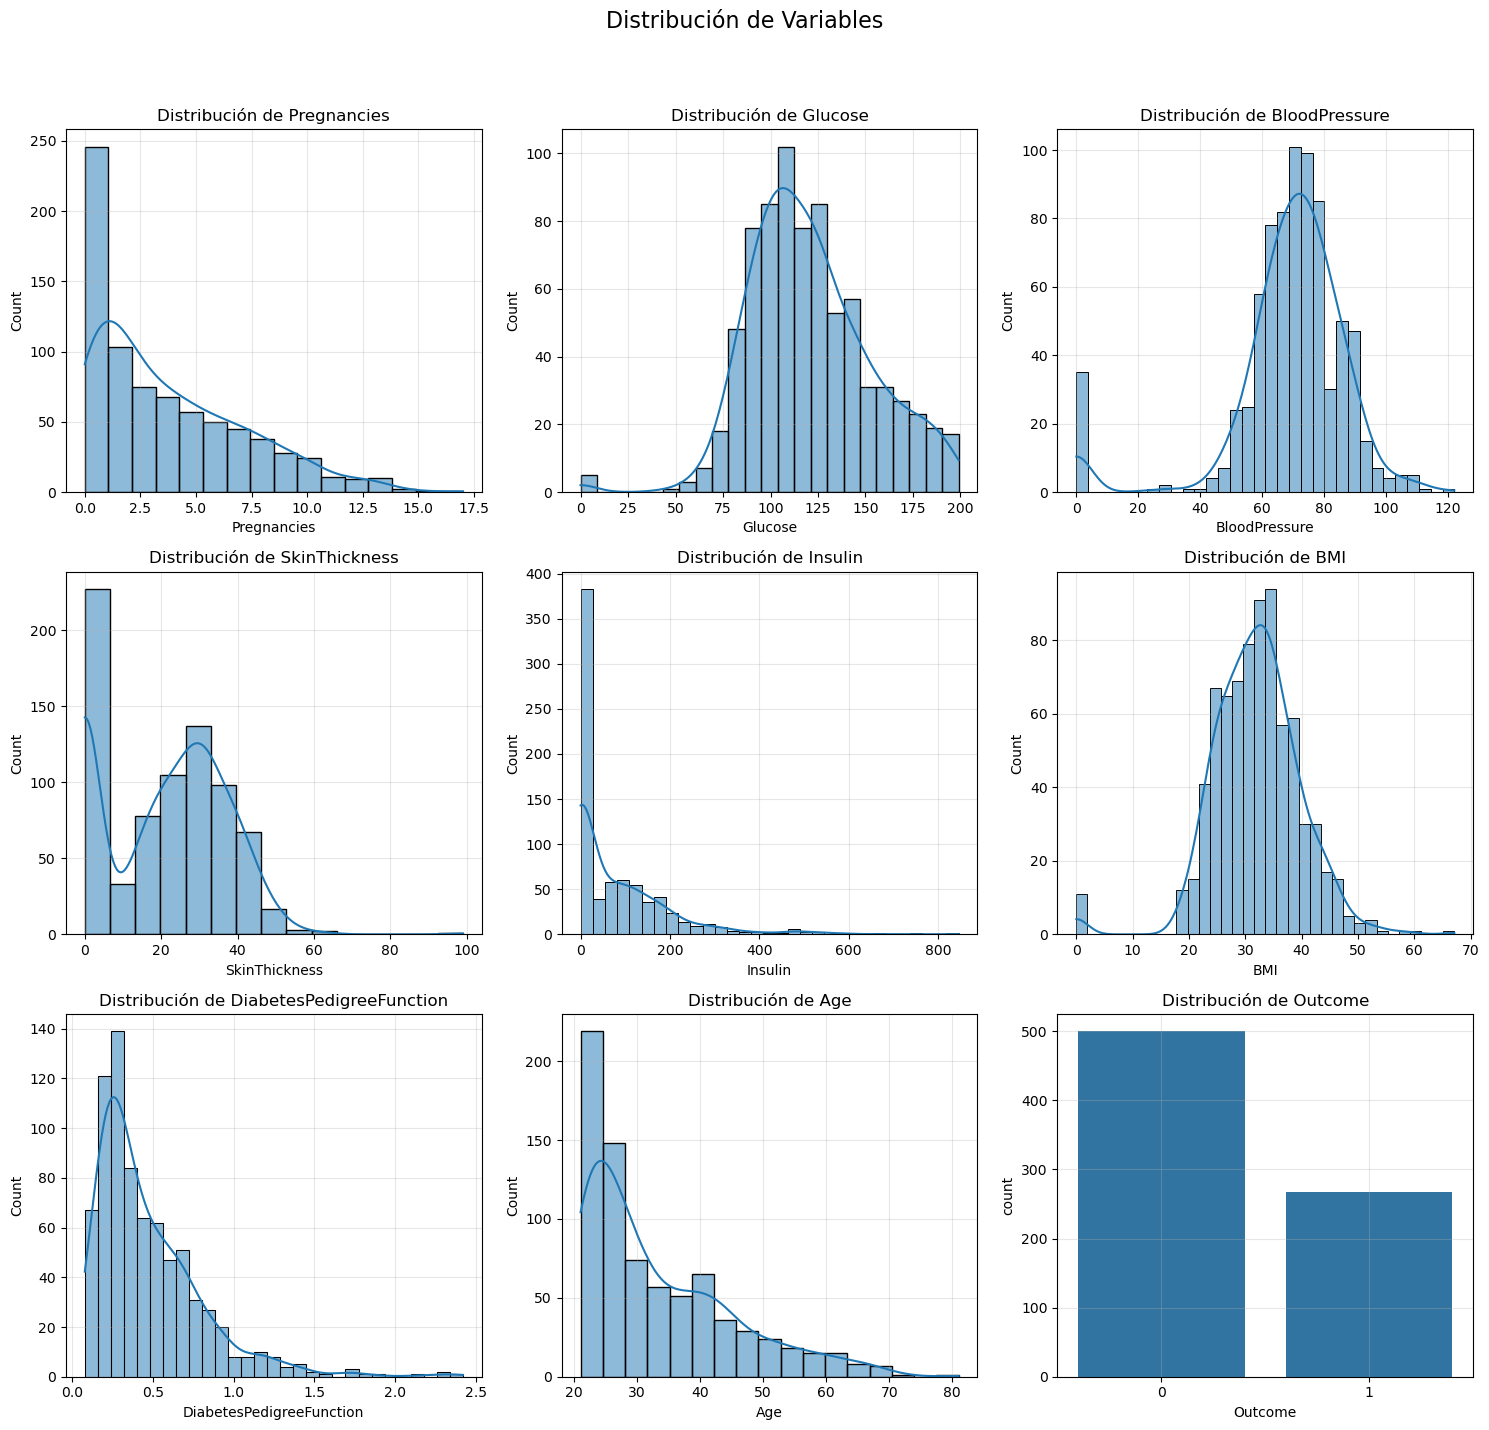

In [100]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

# 1. Estadísticas descriptivas
print("Estadísticas Descriptivas:")
print(df.describe())

# 2. Visualizaciones univariadas
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribución de Variables', fontsize=16)

for idx, column in enumerate(df.columns):
    row = idx // 3
    col = idx % 3
    
    # Para la variable objetivo (Outcome) usar countplot
    if column == 'Outcome':
        sns.countplot(data=df, x=column, ax=axes[row, col])
    else:
        sns.histplot(data=df, x=column, kde=True, ax=axes[row, col])
    
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].grid(True, alpha=0.3)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



* En la distribucion de variables, observamos que existen valores anomalos en las columnas BMI, skinThickness e Insulin, hay muchos valores 0 donde no deberia haberlos

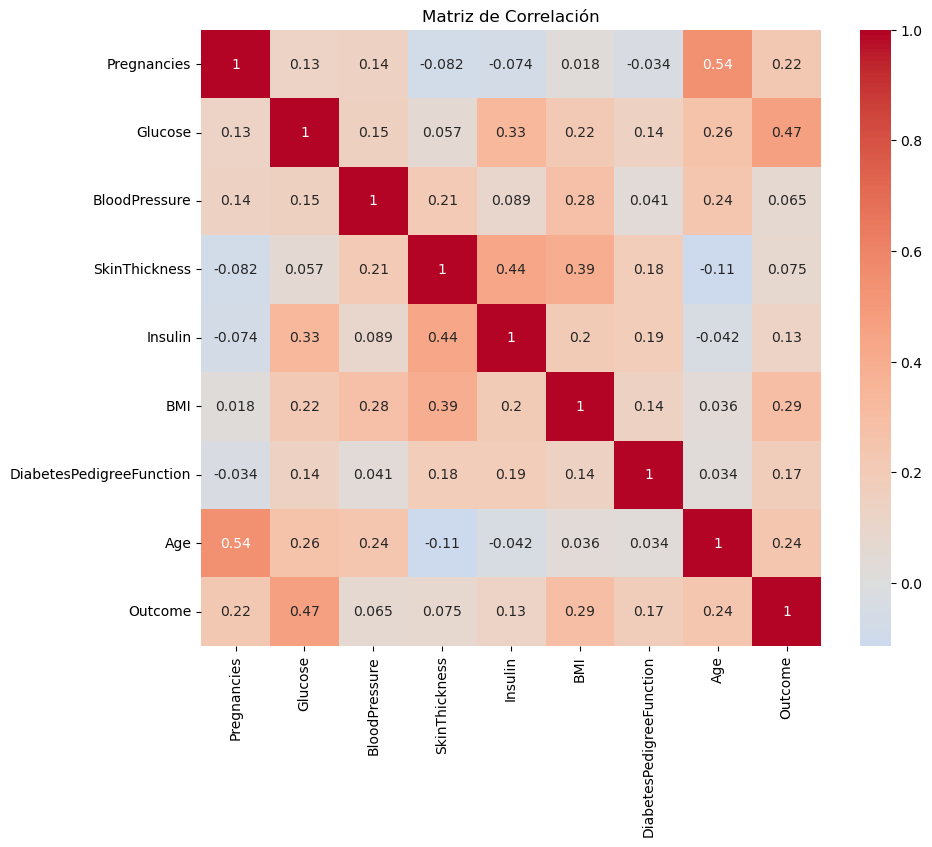

In [101]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

* Se observan correlaciones entre las variables Age y Pregnancies (0.54) siendo esta la correlacion mas alta, en segundo lugar se observa una correlacion un poco mas debil entre Glucose y Outcome (0.47) lo cual indica que el nivel de glucosa esta correlacionado con tener o no diabetes (lo que es cierto cientificamente)

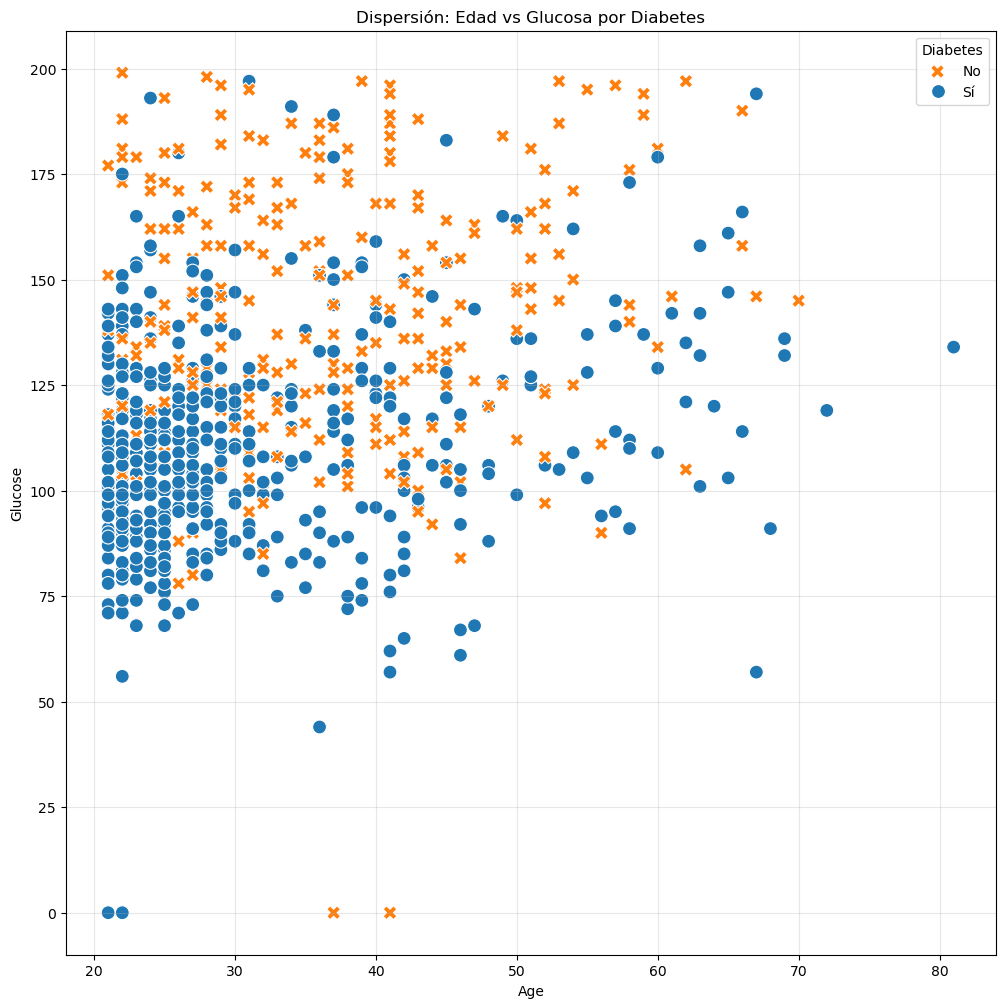

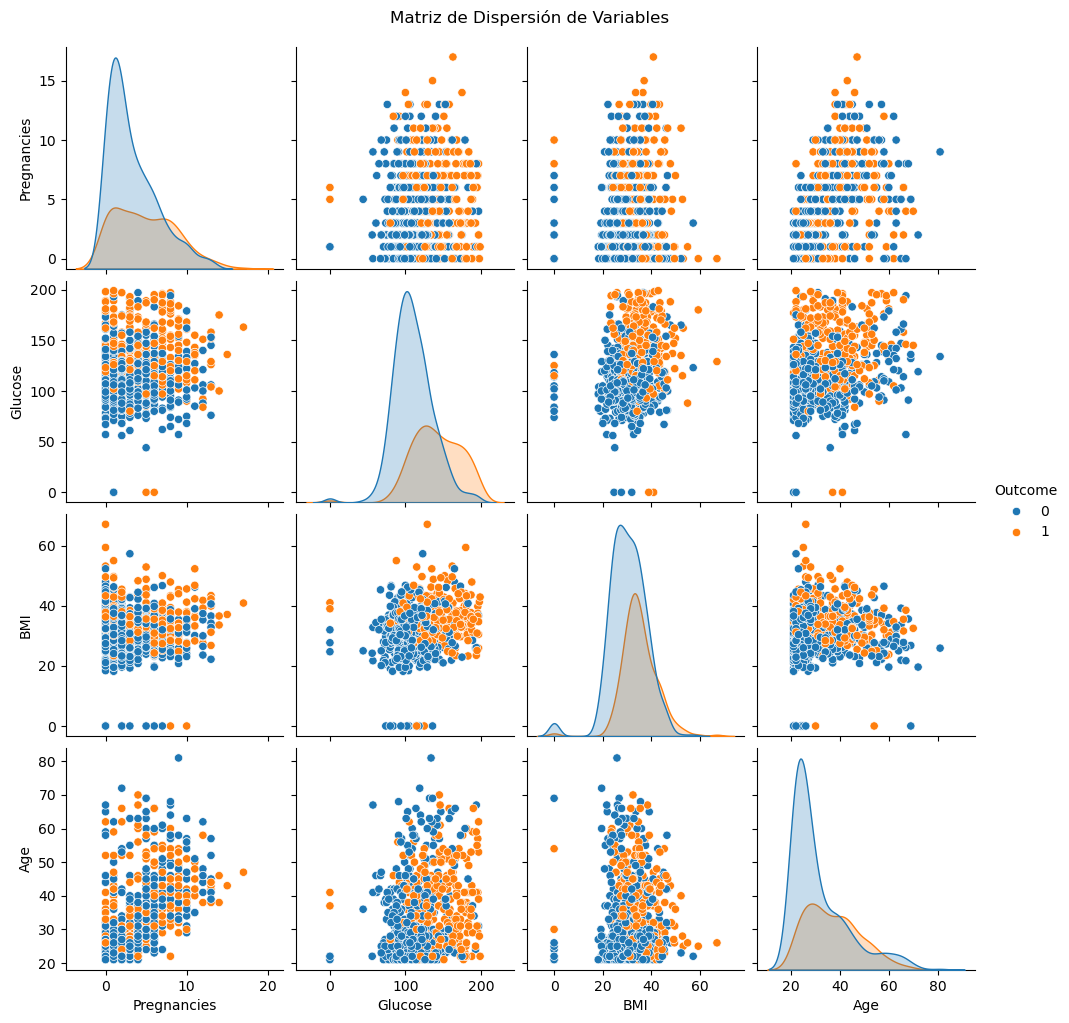

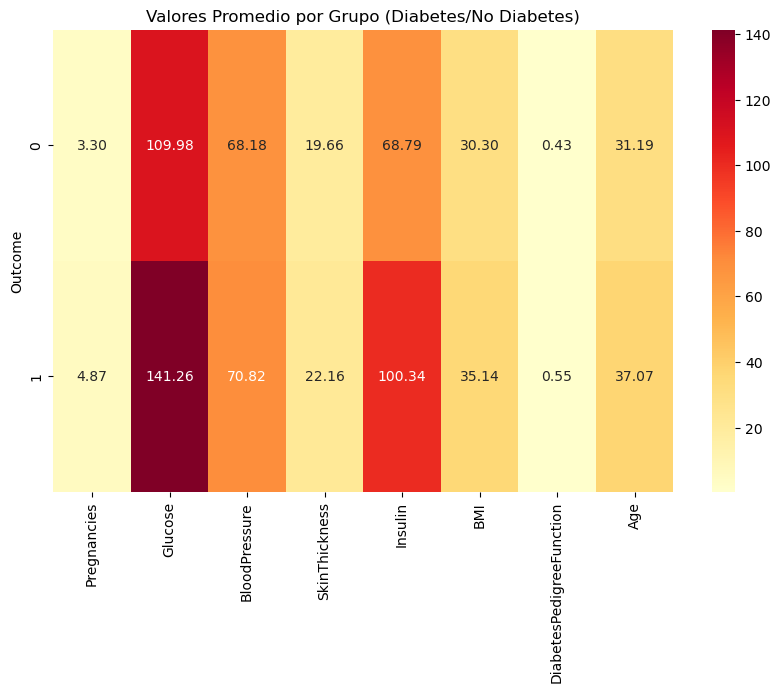


Correlaciones con Diabetes (Outcome):
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


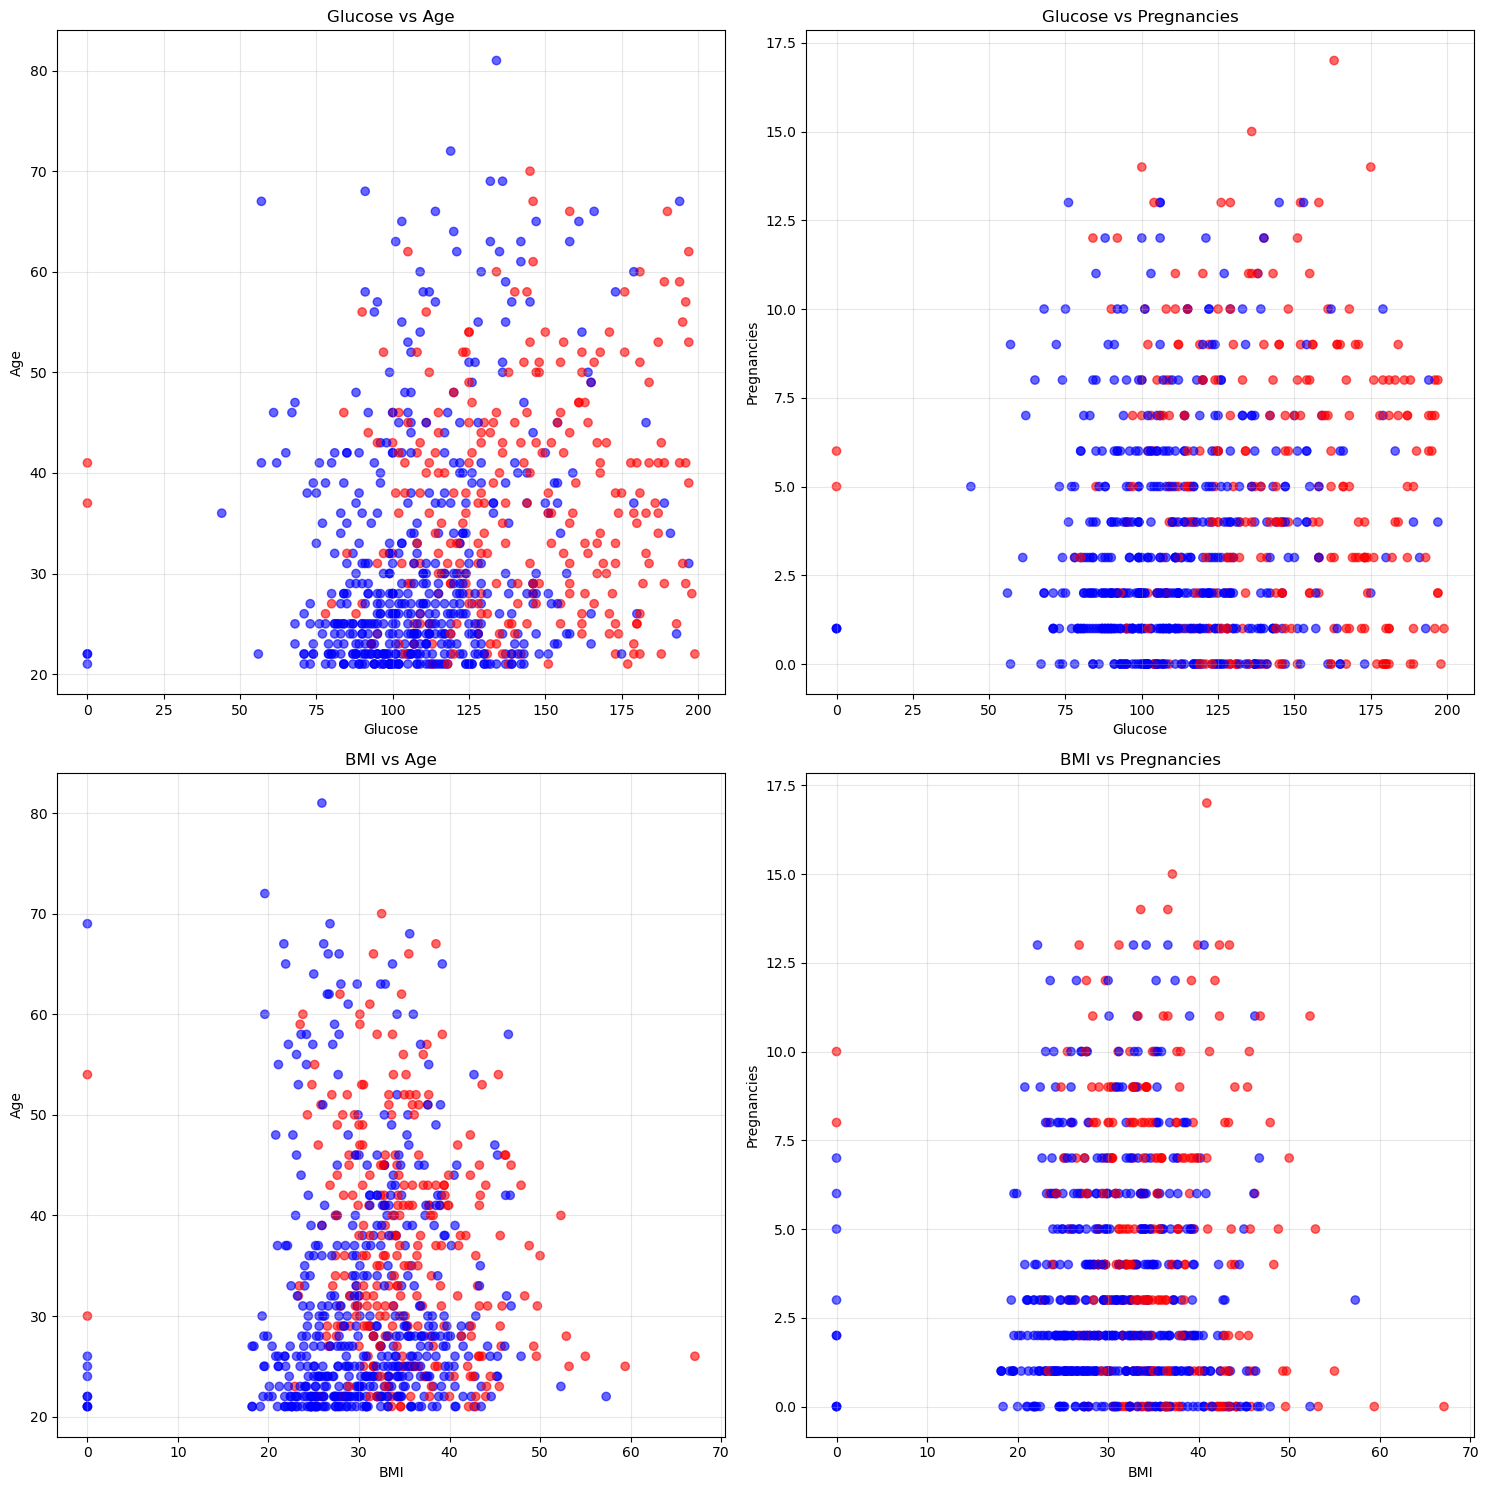

In [102]:
# 1. Boxplots con puntos superpuestos
variables = ['Pregnancies', 'Glucose', 'BMI', 'Age', 'Outcome']
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='Age', y='Glucose', hue='Outcome', style='Outcome', s=100)
plt.title('Dispersión: Edad vs Glucosa por Diabetes')
plt.legend(title='Diabetes', labels=['No', 'Sí'])
plt.grid(True, alpha=0.3)
plt.show()

# 3. Pairplot para variables seleccionadas
sns.pairplot(df[variables], hue='Outcome', diag_kind='kde')
plt.suptitle('Matriz de Dispersión de Variables', y=1.02)
plt.show()

# 4. Mapa de calor de agrupación por Outcome
plt.figure(figsize=(10, 6))
grouped_means = df.groupby('Outcome').mean()
sns.heatmap(grouped_means, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Valores Promedio por Grupo (Diabetes/No Diabetes)')
plt.show()

# 5. Correlaciones con Outcome
outcome_corr = correlation['Outcome'].sort_values(ascending=False)
print("\nCorrelaciones con Diabetes (Outcome):")
print(outcome_corr)

# 6. Scatter plot con múltiples variables
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
variables_scatter = ['Glucose', 'BMI', 'Age', 'Pregnancies']
colors = ['red' if x == 1 else 'blue' for x in df['Outcome']]

for i, var1 in enumerate(['Glucose', 'BMI']):
    for j, var2 in enumerate(['Age', 'Pregnancies']):
        axes[i,j].scatter(df[var1], df[var2], c=colors, alpha=0.6)
        axes[i,j].set_xlabel(var1)
        axes[i,j].set_ylabel(var2)
        axes[i,j].set_title(f'{var1} vs {var2}')
        axes[i,j].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#3. Implementación de Modelos

           Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Random Forest  0.748918   0.682540  0.530864  0.597222  0.698765
1        XGBoost  0.722944   0.623188  0.530864  0.573333  0.678765


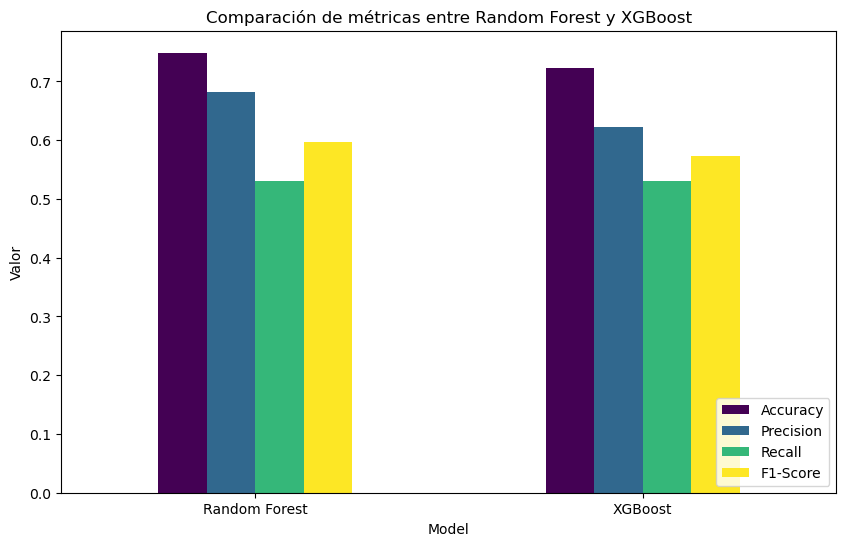

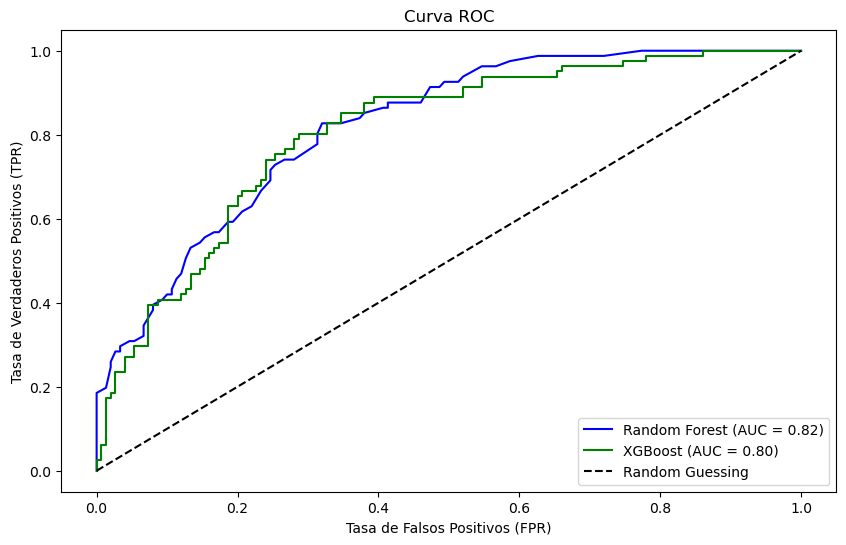

In [103]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, model_name):
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred),
    }
    return metrics

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Evaluación
rf_metrics = evaluate_model(y_test, rf_predictions, "Random Forest")
xgb_metrics = evaluate_model(y_test, xgb_predictions, "XGBoost")

# Mostrar resultados
results = pd.DataFrame([rf_metrics, xgb_metrics])
print(results)

metrics_df = pd.DataFrame([rf_metrics, xgb_metrics]).set_index("Model")

# Gráfico de barras para comparar métricas
metrics_df.drop(columns=["ROC-AUC"]).plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Comparación de métricas entre Random Forest y XGBoost")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Curva ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

rf_roc_auc = auc(rf_fpr, rf_tpr)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_roc_auc:.2f})", color="blue")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_roc_auc:.2f})", color="green")
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.title("Curva ROC")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.show()


* Observamos que las predicciones de ambos modelos es muy parecida, aunque Random Forest tiene mejor precision (74%) 
* El area bajo la curva ROC de ambos modelos es muy similar, esto implica que entre estos modelos tienen similar capacidad de discriminacion, siendo aqui tambien Random Forest ligeramente mejor
* En conclusion, para este dataset, se recomendaria usar Random Forest para obtener la mejor prediccion


           Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Random Forest  0.740260   0.666667  0.518519  0.583333  0.689259
1        XGBoost  0.753247   0.666667  0.592593  0.627451  0.716296


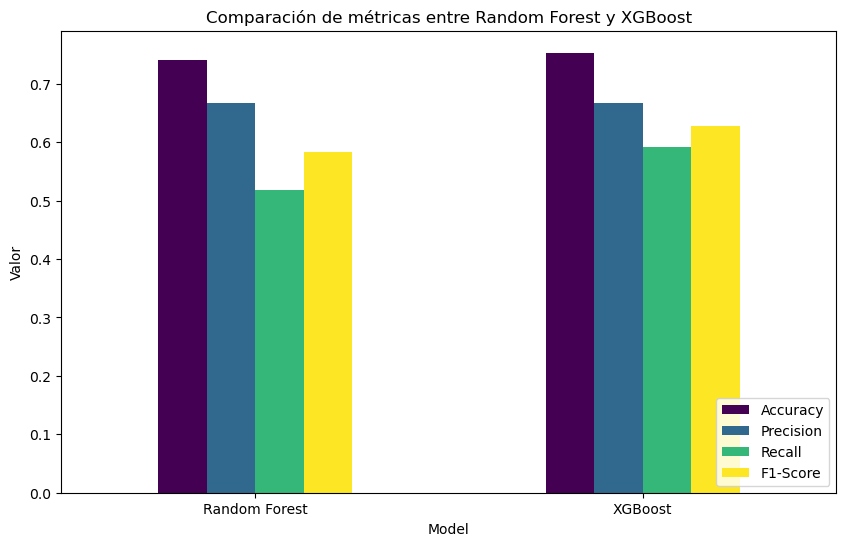

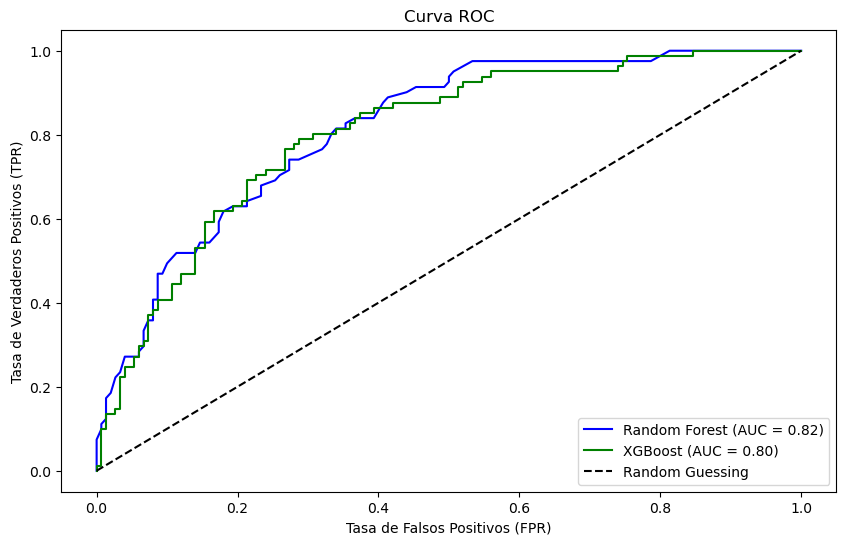

In [104]:
#Debido a que dentro del dataset, existen valores anomalos para columnas que representan mediciones medicas 
#(como grosor de la piel, BMI y presion sanguinea), se realizara otro entrenamiento con estas imputaciones
#Tener en cuenta que al ser datos medicos, imputar las columnas presentes en invalid_cols podria no ser lo mejor, 
#a modo practico, se eligio imputar por la mediana

# Manejo de valores anomalos en columnas que contienen datos medicos

invalid_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Reemplazar ceros con NaN en las columnas correspondientes
df[invalid_cols] = df[invalid_cols].replace(0, np.nan)

# Imputar valores faltantes con la mediana
for col in invalid_cols:
    df[col].fillna(df[col].median(), inplace=True)

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Evaluación
rf_metrics = evaluate_model(y_test, rf_predictions, "Random Forest")
xgb_metrics = evaluate_model(y_test, xgb_predictions, "XGBoost")

# Mostrar resultados
results = pd.DataFrame([rf_metrics, xgb_metrics])
print(results)

metrics_df = pd.DataFrame([rf_metrics, xgb_metrics]).set_index("Model")

# Gráfico de barras para comparar métricas
metrics_df.drop(columns=["ROC-AUC"]).plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Comparación de métricas entre Random Forest y XGBoost")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Curva ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

rf_roc_auc = auc(rf_fpr, rf_tpr)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_roc_auc:.2f})", color="blue")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_roc_auc:.2f})", color="green")
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.title("Curva ROC")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.show()

* Si se realizan las imputaciones por la mediana, para valores medicos incorrectos (ej. BloodPressure = 0 o SkinThickness = 0) el modelo que mejor se desempenha es el XGBOOST
* Podria no ser del todo correcto imputar datos de medicion medica, debido a la naturaleza de estos 